# Enhancing model pipeline

In the last model, we filled out missing ages and embarked values using the mean, we used the probability fact. Within this model, we are going to first approximate the missing values using SVM and the predict the survived value. In further models, we may try to use the columns name, cabin and ticket.

In [264]:
import pandas as pd
from sklearn import svm, preprocessing
import numpy as np
import traceback

In [85]:
sourceData = pd.read_csv(\
    '../data/train.csv',\
    index_col = 'PassengerId'\
)

In [242]:
# Removes data that we won't use for this model and renames columns for handy programming
def cleanData(data):
    # Creates a copy of the dataset
    dataset = data.copy()
    
    # Renames the columns to be lowecase
    dataset.columns = [
        'survived',
        'dclass',
        'name',
        'sex',
        'age',
        'siblings',
        'parch',
        'ticket',
        'fare',
        'cabin',
        'embarked'
    ]
    
    dataset.replace({ 'embarked': { 'S': 1, 'C': 2, 'Q': 3 }}, inplace = True)
    dataset.replace({ 'sex': { 'male': 1, 'female': 2 }}, inplace = True)
    
    return dataset.drop(columns = ['name', 'cabin', 'ticket'])

cleanSourceData = cleanData(sourceData)
cleanSourceData.head()

,survived,dclass,sex,age,siblings,parch,fare,embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,1.0
2,1,1,2,38.0,1,0,71.2833,2.0
3,1,3,2,26.0,0,0,7.9250,1.0
4,1,1,2,35.0,1,0,53.1000,1.0
5,0,3,1,35.0,0,0,8.0500,1.0


In [243]:
def prepareDatasetForModel(dataset, predict_column):
    records_id = dataset.index.values
    X = dataset.drop(columns = [predict_column, 'survived']).values
    y = dataset[predict_column].values
    return (records_id, X, y)

In [244]:
submodelData = cleanSourceData.dropna()
submodelData.head()

,survived,dclass,sex,age,siblings,parch,fare,embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,1.0
2,1,1,2,38.0,1,0,71.2833,2.0
3,1,3,2,26.0,0,0,7.9250,1.0
4,1,1,2,35.0,1,0,53.1000,1.0
5,0,3,1,35.0,0,0,8.0500,1.0


## Training the age predictor

In [245]:
(records_with_id, age_model_records, age_fit) = prepareDatasetForModel(submodelData, 'age')

In [246]:
age_predictor_svr = svm.SVR(gamma='scale', C = 1)
age_predictor_svr.fit(age_model_records, age_fit)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## Training Fare predictor

In [247]:
(_, fare_model_records, fare_fit) = prepareDatasetForModel(submodelData, 'fare')

In [248]:
fare_predictor_svr = svm.SVR(gamma='scale', C = 1)
fare_predictor_svr.fit(fare_model_records, fare_fit)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## Training Embarked port predictor

In [249]:
(_, embarked_model_records, embarked_fit) = prepareDatasetForModel(submodelData, 'embarked')
classified_embarked_fit = pd.Series(embarked_fit).astype(int).values

In [250]:
embarked_predictor_svc = svm.LinearSVC()
embarked_predictor_svc.fit(fare_model_records, classified_embarked_fit)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Training the Survived predictor

In [251]:
cleanSourceData.head()

,survived,dclass,sex,age,siblings,parch,fare,embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,1.0
2,1,1,2,38.0,1,0,71.2833,2.0
3,1,3,2,26.0,0,0,7.9250,1.0
4,1,1,2,35.0,1,0,53.1000,1.0
5,0,3,1,35.0,0,0,8.0500,1.0


In [252]:
def preparePredictRow(row, predict_column):
    return row.drop(predict_column).drop('survived').values

In [253]:
filled_ages = []
filled_fare = []
filled_embarked = []
for index, row in cleanSourceData.iterrows(): 
    try:
        # Predict age if the record does not have it
        if np.isnan(row.age):
            record_prediction = preparePredictRow(row, 'age')
            [age] = age_predictor_svr.predict([record_prediction])
            filled_ages.append(age)
        else:
            filled_ages.append(row.age)

        # Predict embarked if the record does not provide that info
        if np.isnan(row.embarked):
            record_prediction = preparePredictRow(row, 'embarked')
            [embarked] = embarked_predictor_svc.predict([record_prediction])
            filled_embarked.append(embarked)
        else:
            filled_embarked.append(row.embarked)

        # Predict fare if the record does not provide that info
        if np.isnan(row.fare):
            record_prediction = preparePredictRow(row, 'fare')
            [fare] = fare_predictor_svr.predict([record_prediction])
            filled_fare.append(fare)
        else:
            filled_fare.append(row.fare)
    except ValueError:
        print 'An error ocurred while predicting index: ', index, ' and row is ', row

In [254]:
completedTrainData = cleanSourceData.assign(fare = filled_fare, age = filled_ages, embarked = filled_embarked)

In [255]:
X = completedTrainData.drop(columns = ['survived']).values
y = completedTrainData.survived.values

survived_predictor = svm.SVC(gamma='scale', C = 0.9)
survived_predictor.fit(X, y)

SVC(C=0.9, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Predicting over the test set

In [273]:
sourceTestData = pd.read_csv('../data/test.csv', index_col = 'PassengerId')

# Removes data that we won't use for this model and renames columns for handy programming
def cleanTestData(data):
    # Creates a copy of the dataset
    dataset = data.copy()
    
    # Renames the columns to be lowecase
    dataset.columns = [
        'dclass',
        'name',
        'sex',
        'age',
        'siblings',
        'parch',
        'ticket',
        'fare',
        'cabin',
        'embarked'
    ]
    
    dataset.replace({ 'embarked': { 'S': 1, 'C': 2, 'Q': 3 }}, inplace = True)
    dataset.replace({ 'sex': { 'male': 1, 'female': 2 }}, inplace = True)
    
    return dataset.drop(columns = ['name', 'cabin', 'ticket'])

testData = cleanTestData(sourceTestData)
testData.head()

,dclass,sex,age,siblings,parch,fare,embarked
PassengerId,,,,,,,
892,3,1,34.5,0,0,7.8292,3
893,3,2,47.0,1,0,7.0000,1
894,2,1,62.0,0,0,9.6875,3
895,3,1,27.0,0,0,8.6625,1
896,3,2,22.0,1,1,12.2875,1


In [284]:
predicted_rows = []
for index, row in testData.iterrows(): 
    person_sex = row.sex
    person_siblings = row.siblings
    person_parch = row.parch
    person_class = row.dclass
    
    maybe_person_age = row.age    
    maybe_person_fare = row.fare
    maybe_person_embarked = row.embarked
    
    person_age = None
    person_fare = None
    person_embarked = None
    
    # Predict record age
    if (np.isnan(maybe_person_age)):
        submodel_person_features = [
            person_class,
            person_sex,
            person_siblings,
            person_parch,
            maybe_person_fare,
            maybe_person_embarked
        ]
        person_age = age_predictor_svr.predict([submodel_person_features])[0]
    else:
        person_age = maybe_person_age
        
    # Predict person fare
    if (np.isnan(maybe_person_fare)):
        submodel_person_features = [
            person_class,
            person_sex,
            maybe_person_age,
            person_siblings,
            person_parch,
            maybe_person_embarked
        ]
        person_fare = fare_predictor_svr.predict([submodel_person_features])[0]
    else:
        person_fare = maybe_person_fare
        
    # Predict person embarked
    if (np.isnan(maybe_person_embarked)):
        submodel_person_features = [
            person_class,
            person_sex,
            maybe_person_age,
            person_siblings,
            person_parch,
            maybe_person_fare
        ]
        person_embarked = embarked_predictor_svc.predict([submodel_person_features])[0]
    else:
        person_embarked = maybe_person_embarked
        
    person_features = [
        person_class,
        person_sex,
        person_age,
        person_siblings,
        person_parch,
        person_fare,
        person_embarked
    ]
    
    [person_survived] = survived_predictor.predict([person_features])
    
    person_data_filled = {
        'survived': person_survived,
        'class': person_class,
        'sex': person_sex,
        'age': person_age,
        'siblings': person_siblings,
        'parch': person_parch,
        'fare': person_fare,
        'embarked': person_embarked
    }
    
    predicted_rows.append(person_data_filled)

predictedDataset = pd.DataFrame(predicted_rows)
predictedDataset.head()

,age,class,embarked,fare,parch,sex,siblings,survived
0,34.5,3.0,3.0,7.8292,0.0,1.0,0.0,0
1,47.0,3.0,1.0,7.0000,0.0,2.0,1.0,0
2,62.0,2.0,3.0,9.6875,0.0,1.0,0.0,0
3,27.0,3.0,1.0,8.6625,0.0,1.0,0.0,0
4,22.0,3.0,1.0,12.2875,1.0,2.0,1.0,0


## Looking at the predicted data

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

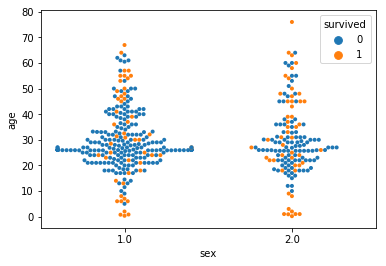

In [288]:
_ = sns.swarmplot(
    x ='sex',
    y = 'age',
    hue = 'survived',
    data = predictedDataset,
    s = 4
)

_ = plt.title('')
_ = plt.xlabel('sex')
_ = plt.ylabel('age')


plt.show()

In [289]:
predictedDataset\
    .drop(columns = ['class', 'sex', 'age', 'siblings', 'parch', 'fare', 'embarked'])\
    .to_csv('../results/notebook-second-svm-balanced.csv')